In [2]:
#!unrar x "/content/Balls.rar" "/content"

In [3]:
#Importing librarie
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import cv2
from PIL import Image
import keras
import numpy as np
import random
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from keras.layers import LeakyReLU
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPool2D, AvgPool2D
from keras.layers import UpSampling2D
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Add, Multiply
from keras.losses import mse, binary_crossentropy
import keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

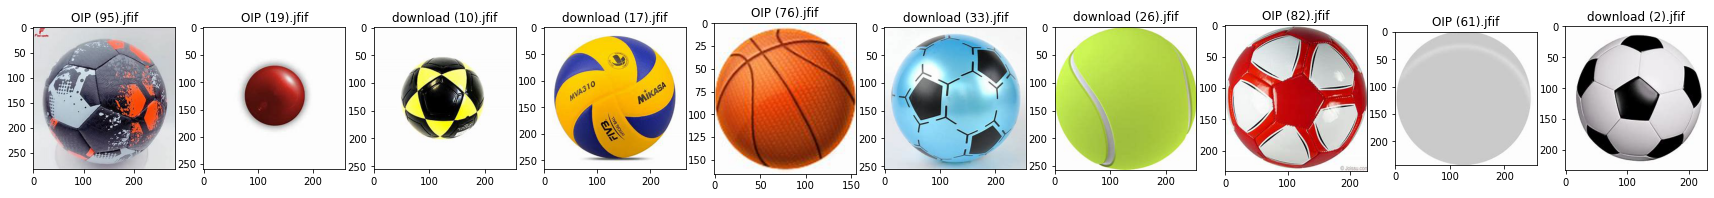

In [23]:
plt.figure(figsize=(30,20))
img_folder=r"/content/Balls"
for i in range(10):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=Image.open(image_path)
    ax=plt.subplot(1,10,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [5]:
img_size = 128
def create_datasets(ROOT):
    imgs = []
    for f in (os.listdir(ROOT)):
        img = cv2.imread(ROOT+'/'+f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, ( img_size , img_size ))
        imgs.append(img)    
    imgs = np.array(imgs)
    imgs = np.divide(imgs,255)
    return imgs
train_x = create_datasets('/content/Balls')

In [6]:
train_x.shape

(139, 128, 128, 3)

In [7]:
latent_dims = 10

In [8]:
encoder_in = Input(shape=(img_size,img_size,3))  
encoder_l1 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same', input_shape=(64,64,3))(encoder_in)
encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = Activation(LeakyReLU(0.2))(encoder_l1)

encoder_l1 = Conv2D(filters=64, kernel_size=5, strides=2, padding='same')(encoder_l1)
encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = Activation(LeakyReLU(0.2))(encoder_l1)


encoder_l2 = Conv2D(filters=128, kernel_size=5, strides=2, padding='same')(encoder_l1)
encoder_l2 = BatchNormalization()(encoder_l2)
encoder_l2 = Activation(LeakyReLU(0.2))(encoder_l2)

encoder_l3 = Conv2D(filters=256, kernel_size=5, strides=2, padding='same')(encoder_l2)
encoder_l3 = BatchNormalization()(encoder_l3)
encoder_l3 = Activation(LeakyReLU(0.2))(encoder_l3)


encoder_l4 = Conv2D(filters=512, kernel_size=5, strides=2, padding='same')(encoder_l3)
encoder_l4 = BatchNormalization()(encoder_l4)
encoder_l4 = Activation(LeakyReLU(0.2))(encoder_l4)

flatten = Flatten()(encoder_l4)

encoder_dense = Dense(1024)(flatten)
encoder_dense = BatchNormalization()(encoder_dense)
encoder_out = Activation(LeakyReLU(0.2))(encoder_dense)


mu = Dense(latent_dims)(encoder_out)
log_var = Dense(latent_dims)(encoder_out)


epsilon = Input(tensor=K.random_normal(shape=(K.shape(mu)[0], latent_dims)))  ##INPUT EPSILON FOR RANDOM SAMPLING

sigma = Lambda(lambda x: K.exp(0.5 * x))(log_var) # CHANGE log_var INTO STANDARD DEVIATION(sigma)
z_eps = Multiply()([sigma, epsilon])

z = Add()([mu, z_eps])

encoder=Model([encoder_in,epsilon], z, name = "Encoder")
encoder.summary()


Instructions for updating:
Colocations handled automatically by placer.


Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  2432        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [9]:
decoder = Sequential()
decoder.add(Dense(1024, input_shape=(latent_dims,)))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Dense(8192))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Reshape(target_shape=(4,4,512)))

decoder.add(Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))


decoder.add(Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Conv2DTranspose(filters=3, kernel_size=5, strides=1, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation('sigmoid'))

decoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              11264     
                                                                 
 batch_normalization_6 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 8192)              8396800   
                                                                 
 batch_normalization_7 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 8192)              0

In [10]:
vae_preds = decoder(z)
vae = Model( [encoder_in, epsilon] , vae_preds, name = "VAE")
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  2432        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                               

In [11]:
def reconstruction_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

def kl_loss(y_true, y_pred):
    kl_loss = - 0.5 * K.mean(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
    return kl_loss

def vae_loss(y_true, y_pred):
    return reconstruction_loss(y_true, y_pred) + 0.03 * kl_loss(y_true, y_pred)   #scaling kl_loss by 0.03 seem to help

In [12]:
vae.compile(optimizer='adam', loss=vae_loss , metrics=[reconstruction_loss, kl_loss])

In [13]:
vae.fit(train_x, train_x, epochs=300, batch_size=100)

Train on 139 samples
Epoch 1/300
139/139 [==============================] - 14s 101ms/sample - loss: 22.9727 - reconstruction_loss: 0.1562 - kl_loss: 760.2506
Epoch 2/300
139/139 [==============================] - 1s 5ms/sample - loss: 17.7897 - reconstruction_loss: 0.1465 - kl_loss: 588.2753
Epoch 3/300
139/139 [==============================] - 1s 5ms/sample - loss: 244.2356 - reconstruction_loss: 0.1478 - kl_loss: 8136.3931
Epoch 4/300
139/139 [==============================] - 1s 5ms/sample - loss: 342.9397 - reconstruction_loss: 0.1432 - kl_loss: 11426.6250
Epoch 5/300
139/139 [==============================] - 1s 5ms/sample - loss: 0.7910 - reconstruction_loss: 0.1379 - kl_loss: 21.6959
Epoch 6/300
139/139 [==============================] - 1s 5ms/sample - loss: 0.5007 - reconstruction_loss: 0.1364 - kl_loss: 12.0388
Epoch 7/300
139/139 [==============================] - 1s 5ms/sample - loss: 0.8449 - reconstruction_loss: 0.1440 - kl_loss: 23.4349
Epoch 8/300
139/139 [===========

In [14]:
def plot_images(rows, cols, images, title):
    grid = np.zeros(shape=(rows*128, cols*128, 3))
    for row in range(rows):
        for col in range(cols):
            grid[row*128:(row+1)*128, col*128:(col+1)*128, :] = images[row*cols + col]

    plt.figure(figsize=(20,10))       
    plt.imshow(grid)
    plt.title(title)
    plt.show()

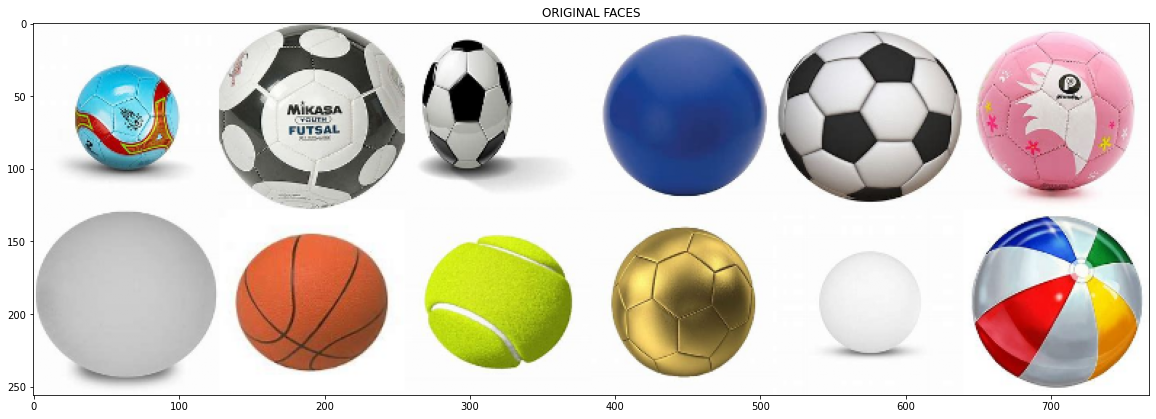

In [25]:
predictions = train_x[80:92]
plot_images(2,6,predictions,"ORIGINAL FACES")

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


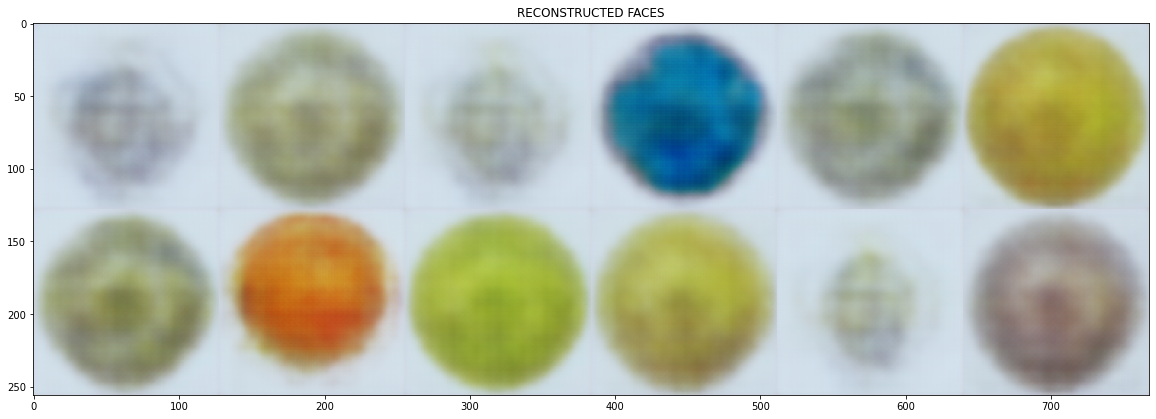

In [16]:
predictions  = vae.predict(train_x[80:92])
plot_images(2,6,predictions, "RECONSTRUCTED FACES")

In [19]:
#@title Number of generated Images  
integer_slider = 12 #@param {type:"slider", min:1, max:12, step:1}
print(integer_slider)

12


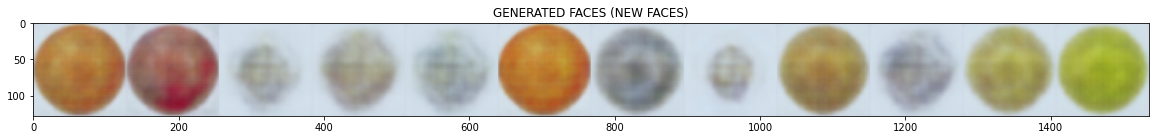

In [20]:
predictions= decoder.predict(np.random.randn(12, latent_dims))
plot_images(1,integer_slider,predictions, "GENERATED FACES (NEW FACES)")